<a href="https://colab.research.google.com/github/mashyko/StyleGANs/blob/master/stylegan_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The code for StyleGAN v1 in TensorFlow==1.15

 adapted from https://github.com/NVlabs/stylegan
 
 reference to  https://qiita.com/Phoeboooo/items/12d21916de56d125f0be and updated by mashyko

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [0]:
!mkdir stylegans
%cd stylegans
!mkdir datasets

!git clone https://github.com/NVlabs/stylegan.git
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan
!ls

mkdir: cannot create directory ‘stylegans’: File exists
/content/drive/My Drive/stylegans
mkdir: cannot create directory ‘datasets’: File exists
fatal: destination path 'stylegan' already exists and is not an empty directory.
fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/drive/My Drive/stylegans/stylegan
config.py	     LICENSE.txt	    README.md	    stylegan-teaser.png
dataset_tool.py      metrics		    results	    training
dnnlib		     pretrained_example.py  run_metrics.py  train.py
generate_figures.py  __pycache__	    stylegan.gif


著者配布の学習済みモデルの'karras2019stylegan-ffhq-1024x1024.pkl' をダウンロードして、ディレクトリ /stylegans_dir/ に保存します。このファイルは、<a href="https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ">この Google Drive </a>にあります。このダウンロードした pretrained model を Google Drive の stylegans_dir にアップロードして下さい。これが終了したら、以下のセル以降を実行します。

In [0]:
%tensorflow_version 1.x
#%pip install tensorflow==1.15

TensorFlow 1.x selected.


In [0]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config


# Initialize TensorFlow.
tflib.init_tf()

# Load pre-trained network.
#url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
#url = 'https://drive.google.com/uc?id=1MOSKeGF0FJcivpBI7s63V9YHloUTORiF' # karras2019stylegan-bedrooms-256x256.pkl
#url = 'https://drive.google.com/uc?id=1MJ6iCfNtMIRicihwRorsM3b7mmtmK9c3' # karras2019stylegan-cars-512x384.pkl
#with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
#    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

*_, Gs = pickle.load(open('../datasets/karras2019stylegan-ffhq-1024x1024.pkl','rb'))















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Pick latent vector.
rnd = np.random.RandomState(210)
latents = rnd.randn(1, Gs.input_shape[1])

In [0]:
# Generate image.
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

In [0]:
# Save image.
result_dir ='results'
!mkdir results
os.makedirs(config.result_dir, exist_ok=True)
png_filename = os.path.join(config.result_dir, 'example210.png')
PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

mkdir: cannot create directory ‘results’: File exists


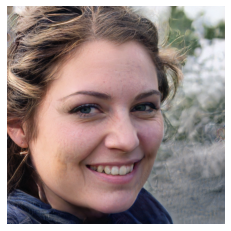

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#画像内に線を表示しない
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')
#画像の読み込み
im = Image.open("results/example210.png")
#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * (len(dst_seeds) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)


def load_Gs(url):
    if url not in _Gs_cache:
        with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]
url_ffhq = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
_Gs_cache = dict()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)


In [0]:
draw_style_mixing_figure(os.path.join(config.result_dir, 'figure03-style-mixing15.png'), load_Gs(url_ffhq),
                         w=1024, h=1024, src_seeds=[3,48,6,63,13,68], dst_seeds=[36,18,26,29,33,84],
                         style_ranges=[range(0,4)]*3+[range(4,8)]*2+[range(8,18)]*1)

OSError: ignored

In [0]:
#画像内に線を表示しない
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')
#画像の読み込み
im = Image.open("results/figure03-style-mixing15.png")
#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

以上

In [0]:
!python pretrained_example.py

!ls results

In [0]:
!python generate_figures.py

別のコード

seed の番号を指定してランダムベクトルを生成すると、毎回同じ順番で同じベクトルが生成されます。こうすると再現性があるので、seed の番号を指定してランダムベクトルを生成することにします。

In [0]:
# Print network details.
Gs.print_layers()
 
# Pick latent vector.
rnd = np.random.RandomState(10)  # seed = 10
latents0 = rnd.randn(1, Gs.input_shape[1])
latents1 = rnd.randn(1, Gs.input_shape[1])
latents2 = rnd.randn(1, Gs.input_shape[1])
latents3 = rnd.randn(1, Gs.input_shape[1])
latents4 = rnd.randn(1, Gs.input_shape[1])
latents5 = rnd.randn(1, Gs.input_shape[1])
latents6 = rnd.randn(1, Gs.input_shape[1])
    
num_split = 39  # 2つのベクトルを39分割
for i in range(40):
        latents = latents6+(latents0-latents6)*i/num_split
        # Generate image.
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
 
        # Save image.
        os.makedirs(config.result_dir, exist_ok=True)
        png_filename = os.path.join(config.result_dir, 'photo'+'{0:04d}'.format(i)+'.png')
        PIL.Image.fromarray(images[0], 'RGB').save(png_filename)


In [0]:
from PIL import Image
import glob
 
files = sorted(glob.glob('results/*.png'))
images = list(map(lambda file: Image.open(file), files))
images[0].save('stylegan.gif', save_all=True, 
               append_images=images[1:], 
               duration=200, loop=0)

style mixing

In [0]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

url_ffhq        = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

_Gs_cache = dict()

def load_Gs(url):
    if url not in _Gs_cache:
        with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]

# ----------------  Style mixing -------------------

def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    
    d1 = np.random.RandomState(503).randn(Gs.input_shape[1])  # seed = 503 のベクトルを取得
    d2 = np.random.RandomState(888).randn(Gs.input_shape[1])  # seed = 888 のベクトルを取得
    
    dx = (d2 - d1)/3  #　３分割で補間
    steps = np.linspace(0,3,4)  # stepsに[0,1,2,3] を代入
    dst_latents = np.stack((d1+dx*step) for step in steps)  # dst_latents にベクトルを４つスタック
        
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)
    
    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * 5), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))  
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h)) 
             
    png_filename = os.path.join(config.result_dir, 'style_mix.png')
    canvas.save(png_filename)

# --------------- main -----------------

def main():
    tflib.init_tf()
    os.makedirs(config.result_dir, exist_ok=True)
    draw_style_mixing_figure(os.path.join(config.result_dir, 'style_mix.png'), load_Gs(url_ffhq), w=1024, h=1024, 
                                                   src_seeds=[11,701,583], dst_seeds=[888,829,1898,1733,1614,845], 
                                                   style_ranges=[range(0,4)]*4)  # style_mixingのレンジ指定

if __name__ == "__main__":
    main()